In [2]:
import arrow
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import Sequential
# TODO:[-] 25-06-03 keras.src 路径是 TensorFlow 2.11 及更高版本中集成在 TensorFlow 内部的 Keras 3 中使用的。
# from keras.src.layers import LSTM, Dropout, Bidirectional, Dense, Masking
from keras.layers import LSTM, Dropout, Bidirectional, Dense, Masking
from pandas import DatetimeIndex
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# from tensorflow.keras.losses import MeanSquaredError
# 可视化结果（如果需要）
import matplotlib.pyplot as plt
import os
import pathlib
import xml.etree.ElementTree as ET
import xarray as xr
import codecs
import datetime
import math

# 先从海浪数据中提取出经纬度，时间，风，海浪高度
# 解析单个文件，并存于字典内
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.layers import Conv1D, MaxPooling1D

In [5]:
forecast_path: str = r'Z:\SOURCE_MERGE_DATA\df_ws_forecast.csv'
realdata_path: str = r'Z:\SOURCE_MERGE_DATA\2024_local_df_utc_183_split.csv'
'''按照三小时一个提取的实况数据路径'''
model_path: str = r'Z:\02TRAINNING_MODEL\fit_model_v3.2_250624_cnn_simaple_0_96.h5'
# scaler_forecast: str = r'Z:\01TRAINNING_DATA\scaler\scaler_forecast_250609.sav'
# scaler_realdata: str = r'Z:\01TRAINNING_DATA\scaler\scaler_realdata_250609.sav'

#### 新增修改，只提取[0,24]的数据

In [6]:
 # step1: 加载标准化后的 预报 | 实况 数据集
# shape: (61,732)
df_forecast = pd.read_csv(forecast_path, encoding='utf-8', index_col=0)
# shape:(61,731)
df_realdata = pd.read_csv(realdata_path, encoding='utf-8', index_col=0)
# 实况拼接有问题需要手动去掉最后一列
# 使用按3小时进行分割的数据不需要去掉最后一列，这样 realdata 与 forecast 的 columns 一致
# df_realdata = df_realdata.drop(df_realdata.columns[-1], axis=1)
df_forecast = df_forecast.iloc[:61, :]

#### 注意此处需要对实况数据与预报数据对其  
实况数据已经进行了拆分（提取了时间间隔为3hour的实况数据）

In [7]:
step=3
start_hour = 0
end_hour = 96

In [8]:
# 计算开始索引
# 注意：start_hour 和 end_hour 是以小时为单位的
start_index=math.ceil(start_hour/step)
# 计算结束索引
end_index=math.ceil(end_hour/step)

In [9]:
df_forecast_split=df_forecast.iloc[start_index:end_index,:]
df_forecast_split.shape

(32, 732)

In [10]:
df_realdata_split= df_realdata.iloc[start_index:end_index,:]
df_realdata_split.shape

(32, 732)

In [11]:
# 手动将上面切分后的 df_forecast_24 与 df_realdata_24 赋值给 df_forecast 和 df_realdata
df_forecast = df_forecast_split
df_realdata = df_realdata_split

#### step2: 将[0,24]的数据作为训练及预测数据

In [12]:
# step3: 数据标准化(提出nan值)
rows: int = df_forecast.shape[0]
cols: int = df_realdata.shape[1]
# TODO:[-] 25-05-28 注意原始数据中: forecast (61,732), real (61,732)
X = df_forecast.values.T.reshape(cols, rows, 1)
# TODO:[*] 25-05-11 注意 y 中有存在 nan
# ValueError: cannot reshape array of size 52776 into shape (732,72,1)
y = df_realdata.values.T.reshape(cols, rows, 1)
# step3-2:对数据进行归一化
# 拍扁数据为二维数组（n*timesteps, feature）进行归一化
X_flat = X.reshape(-1, 1)
y_flat = y.reshape(-1, 1)
# 分别为 X 和 y 定义归一化器（当然如果两者量纲一致，可用同一个 scaler）
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X_flat)
y_scaled = scaler_y.fit_transform(y_flat)
# TODO:[-] 25-06-09 保存归一化器
# joblib.dump(scaler_X, scaler_forecast)
# joblib.dump(scaler_y, scaler_realdata)
# 将归一化后的二维数据恢复为原来的3D形状
X = X_scaled.reshape(X.shape)
y = y_scaled.reshape(y.shape)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### step3: 数据标准化(剔除奇异值)

In [14]:
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)
# step4: 构建模型
X_train = np.nan_to_num(X_train, nan=0.0)
X_test = np.nan_to_num(X_test, nan=0.0)
y_train = np.nan_to_num(y_train, nan=0.0)
y_test = np.nan_to_num(y_test, nan=0.0)

#### step4: 构建模型

In [15]:
model = Sequential()

# 1. Masking层（既然您确认它没问题，我们保留）
model.add(Masking(mask_value=0.0, input_shape=(32, 1)))

# 2. Conv1D层：为每个时间步（包括初始步）创建局部特征
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal'))

# 3. Bidirectional LSTM层：学习长期依赖关系
#    使用一层双向LSTM，它已经足够强大来捕捉序列模式。
#    units=100 是一个比较均衡的选择。
model.add(Bidirectional(LSTM(units=100, return_sequences=True, activation='tanh')))
model.add(Dropout(0.2))

# 4. Dense输出层：将LSTM在每个时间步的输出映射到最终的预测值
model.add(Dense(1))

# 编译模型
model.compile(optimizer='adam', loss='mse')

# 打印模型结构，观察其参数量是否比您之前的模型少了很多
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 32, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 32, 64)            256       
                                                                 
 bidirectional (Bidirectiona  (None, 32, 200)          132000    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 200)           0         
                                                                 
 dense (Dense)               (None, 32, 1)             201       
                                                                 
Total params: 132,457
Trainable params: 132,457
Non-trainable params: 0
__________________________________________________

In [16]:
from keras.callbacks import EarlyStopping

# 定义EarlyStopping回调
# patience=15: 如果验证集损失连续15轮没有下降，就停止训练
# restore_best_weights=True: 停止后，自动把模型权重恢复到val_loss最低的那一轮
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# 训练模型
history = model.fit(X_train, y_train, 
                    epochs=200, 
                    batch_size=16, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping]) # 启用回调

model.save(model_path)

Epoch 1/200
37/37 [==============================] - 8s 33ms/step - loss: 0.0295 - val_loss: 0.0236
Epoch 2/200
37/37 [==============================] - 0s 13ms/step - loss: 0.0205 - val_loss: 0.0211
Epoch 3/200
37/37 [==============================] - 0s 14ms/step - loss: 0.0191 - val_loss: 0.0205
Epoch 4/200
37/37 [==============================] - 0s 13ms/step - loss: 0.0187 - val_loss: 0.0203
Epoch 5/200
37/37 [==============================] - 0s 12ms/step - loss: 0.0184 - val_loss: 0.0205
Epoch 6/200
37/37 [==============================] - 1s 14ms/step - loss: 0.0182 - val_loss: 0.0201
Epoch 7/200
37/37 [==============================] - 0s 12ms/step - loss: 0.0183 - val_loss: 0.0201
Epoch 8/200
37/37 [==============================] - 1s 14ms/step - loss: 0.0181 - val_loss: 0.0199
Epoch 9/200
37/37 [==============================] - 0s 12ms/step - loss: 0.0180 - val_loss: 0.0200
Epoch 10/200
37/37 [==============================] - 0s 13ms/step - loss: 0.0181 - val_loss: 0.0210

#### step5: 模型评估

* 注意此处存在一个隐藏的bug，此处不能使用`X_test`是作为训练时的对比的真实数据，应该采用`y_train`

In [17]:
y_pred=model.predict(X_test)

5/5 [==============================] - 1s 6ms/step


In [18]:
y_pred.shape

(147, 32, 1)

 TODO:[*] 25-06-19 测试数据应使用2025年的实况+风场预报  
 暂时将2024年的数据再进行切分

 1. 使用 scaler_y 来进行反归一化，因为 y_pred 是对 y_scaled 的预测
 2. 修改变量名以反映其真实含义

In [19]:
y_pred_denormalize=scaler_y.inverse_transform(y_pred.reshape(-1, 1))

3. 将反归一化后的数据恢复为与 y_test 相同的3D形状  


In [20]:
y_pred_denormalize = y_pred_denormalize.reshape(y_pred.shape)

In [21]:
y_pred_denormalize.shape

(147, 32, 1)

* 注意numpy.ndarray可以通过 `arr[:,:,x]` 进行切分，类似于 `df.iloc[:,:,x]`

In [22]:
y_pred_finally=y_pred_denormalize[:,:,0]

In [23]:
x_test_denormalize=scaler_X.inverse_transform(X_test.reshape(-1, 1))
x_test_denormalize = x_test_denormalize.reshape(X_test.shape)
x_test_denormalize=x_test_denormalize[:,:,0]
x_test_denormalize.shape

(147, 32)

In [24]:
def compute_rmse(x_series: pd.Series, y_series: pd.Series) -> pd.Series:
    """
        计算 x_series 与 y_series 的RMSE
    :param x_series:
    :param y_series:
    :return:
    """
    # 计算差值的平方
    squared_errors = (x_series - y_series) ** 2

    # 计算每列的均方误差 (MSE)
    mse_per_column = squared_errors.mean(axis=0)  # axis=0 表示按列计算均值

    # 计算每列的均方根误差 (RMSE)
    rmse = np.sqrt(mse_per_column)
    return rmse

In [25]:
rmse_series = compute_rmse(y_pred_finally, x_test_denormalize)

In [26]:
rmse_series

array([1.5963979, 3.5402365, 1.6372408, 1.5920941, 1.7718573, 3.8031242,
       1.7631826, 1.6143762, 1.6887683, 3.170978 , 2.0221314, 1.6887543,
       1.7023795, 3.5326066, 1.8351976, 1.7355433, 1.730252 , 2.7031522,
       1.7703615, 1.6770383, 1.7478429, 2.9722533, 1.8598019, 1.8117071,
       1.7701943, 2.7757876, 1.8338153, 1.7985984, 1.8419927, 2.718462 ,
       1.9339252, 2.046879 ], dtype=float32)

In [27]:
len(rmse_series)

32

In [28]:
rmse_df= pd.DataFrame(rmse_series, columns=['RMSE'])

In [29]:
rmse_df.to_csv('Z:/01TRAINNING_DATA/RMSE/fit_model_v3.2_250624_cnn_simaple_0_96.csv')

In [30]:
df_source=pd.read_csv('Z:/01TRAINNING_DATA/RMSE/source_forecast_rmse.csv')

In [31]:
source_model_series=df_source['0']

In [32]:
# 对于原始风场模型RMSE进行截取
source_model_series_split= source_model_series.iloc[start_index:end_index]

In [33]:
len(source_model_series_split)

32

In [34]:
rmse_series

array([1.5963979, 3.5402365, 1.6372408, 1.5920941, 1.7718573, 3.8031242,
       1.7631826, 1.6143762, 1.6887683, 3.170978 , 2.0221314, 1.6887543,
       1.7023795, 3.5326066, 1.8351976, 1.7355433, 1.730252 , 2.7031522,
       1.7703615, 1.6770383, 1.7478429, 2.9722533, 1.8598019, 1.8117071,
       1.7701943, 2.7757876, 1.8338153, 1.7985984, 1.8419927, 2.718462 ,
       1.9339252, 2.046879 ], dtype=float32)

In [35]:
source_model_series_split=source_model_series_split.to_list()

In [40]:
source_model_series_split

[1.662858703444374,
 1.7121915896506086,
 1.7635146815257834,
 1.8021876033507933,
 1.888381692587024,
 2.08755353320523,
 1.992755072891736,
 1.90351648296798,
 2.0540830114753303,
 2.2027035088631,
 2.29103795375983,
 2.2241049275804845,
 2.245231283553077,
 2.4164258878349005,
 2.49723306448121,
 2.3590475675485605,
 2.536243528261305,
 2.5322141608314324,
 2.6769928567642705,
 2.639958545180855,
 2.8303108506430226,
 2.8931108647651205,
 2.761806187270728,
 2.720971375735356,
 2.732894342265728,
 3.0249838365351085,
 2.969289047701263,
 2.8909393854830467,
 3.0136955761044577,
 3.1727125973712864,
 2.971623102355798,
 3.084218237170166]

绘图

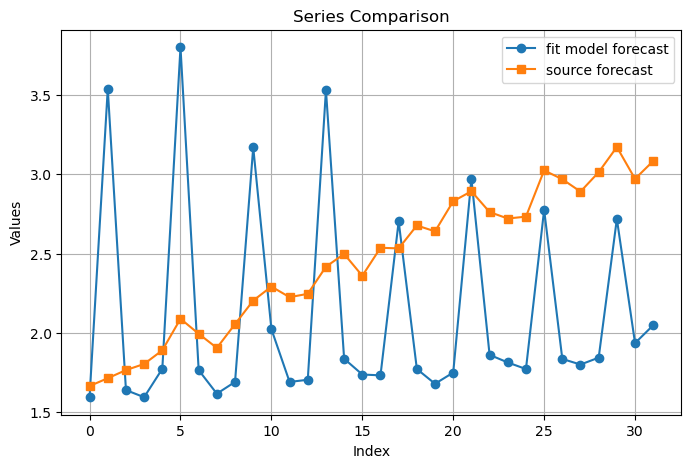

In [36]:
# 创建图表
plt.figure(figsize=(8, 5))  # 设置图像大小
plt.plot(rmse_series, label="fit model forecast", marker='o')  # 绘制第一条线
plt.plot(source_model_series_split, label="source forecast", marker='s')  # 绘制第二条线

# 添加标题和标签
plt.title("Series Comparison")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()  # 显示图例
plt.grid()  # 添加网格线

# 显示图表
plt.show()